# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 65 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=32,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter()
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.283520, Accuracy: 14.84
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.562044, Accuracy: 10.94
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.342010, Accuracy: 11.72
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.366178, Accuracy: 13.28
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.171839, Accuracy: 16.02
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.172309, Accuracy: 18.75
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.095284, Accuracy: 19.14
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.052181, Accuracy: 21.09
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.945577, Accuracy: 19.14
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.004354, Accuracy: 23.05
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.965028, Accuracy: 16.80
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.908854, Accuracy: 23.83
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.913186, Accuracy: 17.97
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.916559, Accuracy: 17.97
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.847929, Accuracy: 21.88
Train Epoc

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.054798, Accuracy: 63.67
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.226591, Accuracy: 58.98
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.131092, Accuracy: 60.55
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.004004, Accuracy: 64.84
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.124301, Accuracy: 58.59
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.085803, Accuracy: 59.77
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.127935, Accuracy: 59.77
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.102013, Accuracy: 62.50
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.092154, Accuracy: 58.59
Train Epoch: 3 [25600/50000 (57%)]	Loss: 0.897204, Accuracy: 69.53
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.058167, Accuracy: 60.16
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.067998, Accuracy: 61.72
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.035334, Accuracy: 62.11
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.007394, Accuracy: 64.84
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.062735, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.665570, Accuracy: 77.34
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.740960, Accuracy: 75.39
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.685989, Accuracy: 76.56
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.791336, Accuracy: 72.27
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.613140, Accuracy: 79.30
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.646771, Accuracy: 77.34
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.753715, Accuracy: 75.39
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.680298, Accuracy: 77.34
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.607517, Accuracy: 76.56
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.686547, Accuracy: 77.34
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.609406, Accuracy: 79.30
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.710044, Accuracy: 75.39
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.735986, Accuracy: 74.22
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.710732, Accuracy: 74.22
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.831494, Accuracy: 7

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.601902, Accuracy: 76.95
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.567792, Accuracy: 78.91
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.635233, Accuracy: 78.91
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.533988, Accuracy: 82.03
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.519029, Accuracy: 81.00

Validation set: Average loss: 0.6997, Accuracy: 3855/5000 (77.00%)

the time of this epoch:[20.00575876235962 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.544931, Accuracy: 80.08
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.613995, Accuracy: 78.12
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.496818, Accuracy: 82.42
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.603903, Accuracy: 80.47
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.512742, Accuracy: 81.64
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.391297, Accuracy: 85.55
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.519749, Accuracy: 82.03
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.413259, Accuracy: 84.77
Train Epoch: 10 [10240

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.491558, Accuracy: 82.81
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.495240, Accuracy: 83.98
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.388718, Accuracy: 89.06
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.380836, Accuracy: 85.16
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.520692, Accuracy: 83.20
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.572230, Accuracy: 79.69
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.485610, Accuracy: 83.98
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.681405, Accuracy: 81.25
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.528673, Accuracy: 83.98
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.467129, Accuracy: 83.98
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.431874, Accuracy: 82.03
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.490198, Accuracy: 83.59
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.424919, Accuracy: 85.16
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.478895, Accuracy: 84.38
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.398191, Accu

Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.441357, Accuracy: 85.55
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.354079, Accuracy: 87.89
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.497859, Accuracy: 83.98
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.342976, Accuracy: 88.28
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.437669, Accuracy: 87.11
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.451198, Accuracy: 83.98
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.323014, Accuracy: 89.06
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.427524, Accuracy: 86.33
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.465269, Accuracy: 83.98
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.425379, Accuracy: 84.77
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.418664, Accuracy: 84.77
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.335355, Accuracy: 88.67
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.511004, Accuracy: 84.38
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.470186, Accuracy: 85.16
Train Epoch: 16 [32000/50000 (71%)]	Loss: 0.3534

Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.345077, Accuracy: 89.45
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.436387, Accuracy: 84.77
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.478555, Accuracy: 83.98
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.480959, Accuracy: 83.20
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.316608, Accuracy: 88.67
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.235265, Accuracy: 92.58
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.439145, Accuracy: 83.20
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.351554, Accuracy: 88.28
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.428313, Accuracy: 87.11
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.407377, Accuracy: 88.28
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.364216, Accuracy: 88.28
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.427282, Accuracy: 82.42
Train Epoch: 19 [40960/50000 (91%)]	Loss: 0.363886, Accuracy: 87.11
Train Epoch: 19 [42240/50000 (94%)]	Loss: 0.322200, Accuracy: 88.28
Train Epoch: 19 [43520/50000 (97%)]	Loss: 0.3349

Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.253716, Accuracy: 91.02
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.213506, Accuracy: 91.41
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.295083, Accuracy: 89.45
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.320526, Accuracy: 89.84
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.248394, Accuracy: 89.45
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.283614, Accuracy: 90.23
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.236786, Accuracy: 91.00

Validation set: Average loss: 0.3891, Accuracy: 4339/5000 (86.00%)

the time of this epoch:[20.06178903579712 s]
Train Epoch: 23 [0/50000 (0%)]	Loss: 0.233334, Accuracy: 91.41
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.243025, Accuracy: 91.41
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.276873, Accuracy: 91.02
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.218510, Accuracy: 91.80
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.334071, Accuracy: 88.67
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.345602, Accuracy: 89.06
Train Epoch: 23

Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.233771, Accuracy: 92.97
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.277341, Accuracy: 90.62
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.291059, Accuracy: 89.84
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.226750, Accuracy: 91.02
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.256663, Accuracy: 91.02
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.268986, Accuracy: 89.45
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.264515, Accuracy: 91.02
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.208152, Accuracy: 92.58
Train Epoch: 26 [11520/50000 (26%)]	Loss: 0.202214, Accuracy: 92.97
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.267907, Accuracy: 90.23
Train Epoch: 26 [14080/50000 (31%)]	Loss: 0.202692, Accuracy: 92.19
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.190762, Accuracy: 92.58
Train Epoch: 26 [16640/50000 (37%)]	Loss: 0.242291, Accuracy: 92.58
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.250507, Accuracy: 90.23
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.286031, Accura

Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.288510, Accuracy: 89.06
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.269749, Accuracy: 91.80
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.180407, Accuracy: 94.92
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.188070, Accuracy: 94.14
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.274026, Accuracy: 89.06
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.214530, Accuracy: 92.97
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.165283, Accuracy: 94.92
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.189989, Accuracy: 93.75
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.205512, Accuracy: 91.80
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.174297, Accuracy: 93.36
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.196812, Accuracy: 92.97
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.254162, Accuracy: 91.80
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.249116, Accuracy: 92.19
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.345509, Accuracy: 89.84
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.3321

Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.244183, Accuracy: 91.02
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.375597, Accuracy: 89.45
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.310469, Accuracy: 88.28
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.251997, Accuracy: 90.62
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.199217, Accuracy: 92.58
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.223533, Accuracy: 91.02
Train Epoch: 32 [32000/50000 (71%)]	Loss: 0.178478, Accuracy: 94.53
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.257965, Accuracy: 92.19
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.245729, Accuracy: 89.84
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.250039, Accuracy: 89.84
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.214073, Accuracy: 91.02
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.213396, Accuracy: 92.19
Train Epoch: 32 [39680/50000 (88%)]	Loss: 0.199232, Accuracy: 92.19
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.170171, Accuracy: 96.09
Train Epoch: 32 [42240/50000 (94%)]	Loss: 0.2036

Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.206003, Accuracy: 92.97
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.272922, Accuracy: 89.45
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.119953, Accuracy: 96.09
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.164199, Accuracy: 95.31
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.169085, Accuracy: 93.36
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.229226, Accuracy: 90.62
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.255246, Accuracy: 90.62
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.254714, Accuracy: 90.50

Validation set: Average loss: 0.3821, Accuracy: 4405/5000 (88.00%)

the time of this epoch:[20.167938709259033 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.187484, Accuracy: 94.92
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.170544, Accuracy: 93.75
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.162520, Accuracy: 93.36
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.118058, Accuracy: 95.31
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.172577, Accuracy: 94.53
Train Epoch: 

Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.175277, Accuracy: 94.14
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.160151, Accuracy: 93.75
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.166079, Accuracy: 93.75
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.151663, Accuracy: 93.36
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.149121, Accuracy: 93.75
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.259445, Accuracy: 92.58
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.154310, Accuracy: 95.31
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.126312, Accuracy: 94.14
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.143688, Accuracy: 94.53
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.151770, Accuracy: 92.97
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.169437, Accuracy: 93.75
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.223793, Accuracy: 94.14
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.144105, Accuracy: 95.70
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.227611, Accuracy: 91.41
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.126188, Accura

Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.087322, Accuracy: 96.88
Train Epoch: 42 [14080/50000 (31%)]	Loss: 0.089976, Accuracy: 96.88
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.126689, Accuracy: 95.31
Train Epoch: 42 [16640/50000 (37%)]	Loss: 0.215587, Accuracy: 92.97
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.135448, Accuracy: 95.70
Train Epoch: 42 [19200/50000 (43%)]	Loss: 0.086255, Accuracy: 97.27
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.131651, Accuracy: 95.31
Train Epoch: 42 [21760/50000 (48%)]	Loss: 0.109011, Accuracy: 95.31
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.120092, Accuracy: 94.92
Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.183702, Accuracy: 93.36
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.172325, Accuracy: 94.14
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.112481, Accuracy: 96.88
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.089645, Accuracy: 96.88
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.263129, Accuracy: 92.58
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.1676

Train Epoch: 45 [24320/50000 (54%)]	Loss: 0.146723, Accuracy: 94.14
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.134250, Accuracy: 94.92
Train Epoch: 45 [26880/50000 (60%)]	Loss: 0.138605, Accuracy: 95.31
Train Epoch: 45 [28160/50000 (62%)]	Loss: 0.131524, Accuracy: 96.48
Train Epoch: 45 [29440/50000 (65%)]	Loss: 0.092940, Accuracy: 96.09
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.115028, Accuracy: 95.70
Train Epoch: 45 [32000/50000 (71%)]	Loss: 0.112827, Accuracy: 94.92
Train Epoch: 45 [33280/50000 (74%)]	Loss: 0.094528, Accuracy: 96.88
Train Epoch: 45 [34560/50000 (77%)]	Loss: 0.163924, Accuracy: 96.09
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.115394, Accuracy: 96.48
Train Epoch: 45 [37120/50000 (82%)]	Loss: 0.109923, Accuracy: 95.70
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.123408, Accuracy: 95.70
Train Epoch: 45 [39680/50000 (88%)]	Loss: 0.064844, Accuracy: 98.44
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.115834, Accuracy: 96.09
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.1504

Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.090524, Accuracy: 96.09
Train Epoch: 48 [37120/50000 (82%)]	Loss: 0.130043, Accuracy: 96.09
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.099530, Accuracy: 97.66
Train Epoch: 48 [39680/50000 (88%)]	Loss: 0.147753, Accuracy: 94.53
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.077720, Accuracy: 96.48
Train Epoch: 48 [42240/50000 (94%)]	Loss: 0.138658, Accuracy: 94.92
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.091701, Accuracy: 96.88
Train Epoch: 48 [35000/50000 (99%)]	Loss: 0.132461, Accuracy: 95.00

Validation set: Average loss: 0.3873, Accuracy: 4479/5000 (89.00%)

the time of this epoch:[19.62441849708557 s]
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.084903, Accuracy: 96.88
Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.097602, Accuracy: 96.88
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.131342, Accuracy: 94.92
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.124704, Accuracy: 95.31
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.060017, Accuracy: 98.44
Train Epoch: 4

Train Epoch: 52 [1280/50000 (3%)]	Loss: 0.104629, Accuracy: 97.27
Train Epoch: 52 [2560/50000 (6%)]	Loss: 0.082682, Accuracy: 98.05
Train Epoch: 52 [3840/50000 (9%)]	Loss: 0.058382, Accuracy: 98.44
Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.112275, Accuracy: 95.70
Train Epoch: 52 [6400/50000 (14%)]	Loss: 0.070387, Accuracy: 98.05
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.080171, Accuracy: 98.05
Train Epoch: 52 [8960/50000 (20%)]	Loss: 0.066180, Accuracy: 97.27
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.107175, Accuracy: 96.48
Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.103885, Accuracy: 95.31
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.110799, Accuracy: 96.48
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.082671, Accuracy: 97.66
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.100956, Accuracy: 96.48
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.123378, Accuracy: 96.48
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.122419, Accuracy: 95.31
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.122328, Accura

Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.096497, Accuracy: 96.09
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.108599, Accuracy: 95.31
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.169184, Accuracy: 94.53
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.059077, Accuracy: 98.05
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.087730, Accuracy: 96.48
Train Epoch: 55 [19200/50000 (43%)]	Loss: 0.126679, Accuracy: 94.92
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.065466, Accuracy: 97.66
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.082367, Accuracy: 97.27
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.103714, Accuracy: 95.70
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.080940, Accuracy: 96.48
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.095398, Accuracy: 96.88
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.061434, Accuracy: 97.66
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.076913, Accuracy: 96.88
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.058425, Accuracy: 98.83
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.0782

Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.096770, Accuracy: 96.48
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.083785, Accuracy: 98.05
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.121289, Accuracy: 95.70
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.097466, Accuracy: 96.09
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.083809, Accuracy: 98.05
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.072118, Accuracy: 97.66
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.070517, Accuracy: 96.88
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.075943, Accuracy: 97.66
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.049286, Accuracy: 98.05
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.060659, Accuracy: 98.44
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.079010, Accuracy: 96.48
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.088786, Accuracy: 96.48
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.116472, Accuracy: 95.31
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.119631, Accuracy: 97.27
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.0935

Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.071335, Accuracy: 96.48
Train Epoch: 61 [37120/50000 (82%)]	Loss: 0.028798, Accuracy: 98.83
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.051085, Accuracy: 97.66
Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.094538, Accuracy: 96.88
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.043812, Accuracy: 97.66
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.038979, Accuracy: 98.05
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.076564, Accuracy: 96.88
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.135733, Accuracy: 95.50

Validation set: Average loss: 0.4240, Accuracy: 4491/5000 (89.00%)

the time of this epoch:[19.851926803588867 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.089391, Accuracy: 96.48
Train Epoch: 62 [1280/50000 (3%)]	Loss: 0.058481, Accuracy: 97.66
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.083998, Accuracy: 98.05
Train Epoch: 62 [3840/50000 (9%)]	Loss: 0.059324, Accuracy: 96.88
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.073346, Accuracy: 97.27
Train Epoch: 

Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.047429, Accuracy: 98.05
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.057394, Accuracy: 98.05
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.052951, Accuracy: 98.44
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.040411, Accuracy: 98.83
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.072673, Accuracy: 97.27
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.053689, Accuracy: 98.05
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.051832, Accuracy: 98.05
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.044431, Accuracy: 97.66
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.051565, Accuracy: 98.44
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.052545, Accuracy: 97.66
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.058106, Accuracy: 98.05
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.064481, Accuracy: 97.27
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.085352, Accuracy: 96.88
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.051846, Accuracy: 98.05
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.047901, Accura

Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.042390, Accuracy: 97.66
Train Epoch: 68 [14080/50000 (31%)]	Loss: 0.031906, Accuracy: 99.22
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.029570, Accuracy: 99.22
Train Epoch: 68 [16640/50000 (37%)]	Loss: 0.084353, Accuracy: 96.88
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.027208, Accuracy: 99.61
Train Epoch: 68 [19200/50000 (43%)]	Loss: 0.050230, Accuracy: 98.83
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.044166, Accuracy: 98.83
Train Epoch: 68 [21760/50000 (48%)]	Loss: 0.046754, Accuracy: 98.05
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.068021, Accuracy: 97.27
Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.051393, Accuracy: 98.05
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.039783, Accuracy: 98.05
Train Epoch: 68 [26880/50000 (60%)]	Loss: 0.063068, Accuracy: 97.66
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.036409, Accuracy: 98.05
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.053055, Accuracy: 97.66
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.0673

Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.068017, Accuracy: 98.05
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.055798, Accuracy: 97.66
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.051467, Accuracy: 98.05
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.028631, Accuracy: 99.22
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.031481, Accuracy: 98.44
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.041331, Accuracy: 97.66
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.070349, Accuracy: 97.66
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.068906, Accuracy: 97.66
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.051763, Accuracy: 98.05
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.023647, Accuracy: 99.22
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.070359, Accuracy: 97.27
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.037489, Accuracy: 99.22
Train Epoch: 71 [39680/50000 (88%)]	Loss: 0.029128, Accuracy: 98.44
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.038812, Accuracy: 98.44
Train Epoch: 71 [42240/50000 (94%)]	Loss: 0.0282

Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.063311, Accuracy: 97.66
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.035478, Accuracy: 99.22
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.068227, Accuracy: 97.27
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.062516, Accuracy: 98.44
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.043540, Accuracy: 98.83
Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.031454, Accuracy: 99.22
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.026369, Accuracy: 99.22
Train Epoch: 74 [35000/50000 (99%)]	Loss: 0.028263, Accuracy: 99.50

Validation set: Average loss: 0.4990, Accuracy: 4494/5000 (89.00%)

the time of this epoch:[19.857731580734253 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.048375, Accuracy: 98.05
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.034514, Accuracy: 98.83
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.027176, Accuracy: 99.61
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.058950, Accuracy: 98.05
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.029272, Accuracy: 98.83
Train Epoch: 

Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.048748, Accuracy: 97.66
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.035918, Accuracy: 97.66
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.075997, Accuracy: 97.27
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.021371, Accuracy: 99.22
Train Epoch: 78 [6400/50000 (14%)]	Loss: 0.051050, Accuracy: 98.05
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.034235, Accuracy: 98.44
Train Epoch: 78 [8960/50000 (20%)]	Loss: 0.013281, Accuracy: 99.61
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.023148, Accuracy: 99.22
Train Epoch: 78 [11520/50000 (26%)]	Loss: 0.033852, Accuracy: 98.44
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.033430, Accuracy: 99.22
Train Epoch: 78 [14080/50000 (31%)]	Loss: 0.020020, Accuracy: 99.61
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.020078, Accuracy: 99.22
Train Epoch: 78 [16640/50000 (37%)]	Loss: 0.024987, Accuracy: 99.22
Train Epoch: 78 [17920/50000 (40%)]	Loss: 0.020150, Accuracy: 99.61
Train Epoch: 78 [19200/50000 (43%)]	Loss: 0.034316, Accura

Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.065276, Accuracy: 98.05
Train Epoch: 81 [14080/50000 (31%)]	Loss: 0.021320, Accuracy: 98.83
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.047389, Accuracy: 97.66
Train Epoch: 81 [16640/50000 (37%)]	Loss: 0.017043, Accuracy: 99.61
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.045914, Accuracy: 97.66
Train Epoch: 81 [19200/50000 (43%)]	Loss: 0.042676, Accuracy: 98.44
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.056879, Accuracy: 98.44
Train Epoch: 81 [21760/50000 (48%)]	Loss: 0.038012, Accuracy: 98.83
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.076732, Accuracy: 96.88
Train Epoch: 81 [24320/50000 (54%)]	Loss: 0.022612, Accuracy: 99.22
Train Epoch: 81 [25600/50000 (57%)]	Loss: 0.072466, Accuracy: 97.66
Train Epoch: 81 [26880/50000 (60%)]	Loss: 0.034322, Accuracy: 98.83
Train Epoch: 81 [28160/50000 (62%)]	Loss: 0.035113, Accuracy: 98.05
Train Epoch: 81 [29440/50000 (65%)]	Loss: 0.019287, Accuracy: 99.61
Train Epoch: 81 [30720/50000 (68%)]	Loss: 0.0347

Train Epoch: 84 [23040/50000 (51%)]	Loss: 0.041015, Accuracy: 98.83
Train Epoch: 84 [24320/50000 (54%)]	Loss: 0.049577, Accuracy: 97.27
Train Epoch: 84 [25600/50000 (57%)]	Loss: 0.032810, Accuracy: 99.22
Train Epoch: 84 [26880/50000 (60%)]	Loss: 0.012305, Accuracy: 100.00
Train Epoch: 84 [28160/50000 (62%)]	Loss: 0.041540, Accuracy: 98.44
Train Epoch: 84 [29440/50000 (65%)]	Loss: 0.021962, Accuracy: 99.61
Train Epoch: 84 [30720/50000 (68%)]	Loss: 0.028376, Accuracy: 99.22
Train Epoch: 84 [32000/50000 (71%)]	Loss: 0.041280, Accuracy: 98.44
Train Epoch: 84 [33280/50000 (74%)]	Loss: 0.039331, Accuracy: 98.44
Train Epoch: 84 [34560/50000 (77%)]	Loss: 0.026126, Accuracy: 98.83
Train Epoch: 84 [35840/50000 (80%)]	Loss: 0.012750, Accuracy: 99.61
Train Epoch: 84 [37120/50000 (82%)]	Loss: 0.024075, Accuracy: 99.61
Train Epoch: 84 [38400/50000 (85%)]	Loss: 0.057181, Accuracy: 97.66
Train Epoch: 84 [39680/50000 (88%)]	Loss: 0.037452, Accuracy: 98.44
Train Epoch: 84 [40960/50000 (91%)]	Loss: 0.016

Train Epoch: 87 [33280/50000 (74%)]	Loss: 0.039289, Accuracy: 99.22
Train Epoch: 87 [34560/50000 (77%)]	Loss: 0.029370, Accuracy: 98.83
Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.019051, Accuracy: 99.22
Train Epoch: 87 [37120/50000 (82%)]	Loss: 0.006719, Accuracy: 100.00
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.029793, Accuracy: 99.22
Train Epoch: 87 [39680/50000 (88%)]	Loss: 0.040236, Accuracy: 98.44
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.013329, Accuracy: 99.22
Train Epoch: 87 [42240/50000 (94%)]	Loss: 0.016733, Accuracy: 99.22
Train Epoch: 87 [43520/50000 (97%)]	Loss: 0.053615, Accuracy: 98.05
Train Epoch: 87 [35000/50000 (99%)]	Loss: 0.021583, Accuracy: 99.50

Validation set: Average loss: 0.5294, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[19.849677085876465 s]
Train Epoch: 88 [0/50000 (0%)]	Loss: 0.014399, Accuracy: 100.00
Train Epoch: 88 [1280/50000 (3%)]	Loss: 0.032936, Accuracy: 99.22
Train Epoch: 88 [2560/50000 (6%)]	Loss: 0.021990, Accuracy: 99.22
Train Ep

Train Epoch: 90 [43520/50000 (97%)]	Loss: 0.015967, Accuracy: 99.61
Train Epoch: 90 [35000/50000 (99%)]	Loss: 0.021304, Accuracy: 98.50

Validation set: Average loss: 0.5517, Accuracy: 4496/5000 (89.00%)

the time of this epoch:[20.0049147605896 s]
Train Epoch: 91 [0/50000 (0%)]	Loss: 0.020441, Accuracy: 99.22
Train Epoch: 91 [1280/50000 (3%)]	Loss: 0.023418, Accuracy: 99.61
Train Epoch: 91 [2560/50000 (6%)]	Loss: 0.013197, Accuracy: 100.00
Train Epoch: 91 [3840/50000 (9%)]	Loss: 0.017646, Accuracy: 99.22
Train Epoch: 91 [5120/50000 (11%)]	Loss: 0.018275, Accuracy: 99.61
Train Epoch: 91 [6400/50000 (14%)]	Loss: 0.013591, Accuracy: 99.22
Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.050771, Accuracy: 98.44
Train Epoch: 91 [8960/50000 (20%)]	Loss: 0.023033, Accuracy: 98.83
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.044380, Accuracy: 98.44
Train Epoch: 91 [11520/50000 (26%)]	Loss: 0.021580, Accuracy: 99.22
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.046667, Accuracy: 98.05
Train Epoch: 91 [

Train Epoch: 94 [6400/50000 (14%)]	Loss: 0.010132, Accuracy: 99.61
Train Epoch: 94 [7680/50000 (17%)]	Loss: 0.030911, Accuracy: 98.83
Train Epoch: 94 [8960/50000 (20%)]	Loss: 0.031998, Accuracy: 98.05
Train Epoch: 94 [10240/50000 (23%)]	Loss: 0.012280, Accuracy: 99.61
Train Epoch: 94 [11520/50000 (26%)]	Loss: 0.025501, Accuracy: 98.83
Train Epoch: 94 [12800/50000 (28%)]	Loss: 0.017768, Accuracy: 99.22
Train Epoch: 94 [14080/50000 (31%)]	Loss: 0.006568, Accuracy: 100.00
Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.017936, Accuracy: 99.22
Train Epoch: 94 [16640/50000 (37%)]	Loss: 0.022945, Accuracy: 98.83
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.032360, Accuracy: 98.83
Train Epoch: 94 [19200/50000 (43%)]	Loss: 0.010158, Accuracy: 100.00
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.020782, Accuracy: 99.22
Train Epoch: 94 [21760/50000 (48%)]	Loss: 0.064854, Accuracy: 98.05
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.020575, Accuracy: 99.61
Train Epoch: 94 [24320/50000 (54%)]	Loss: 0.01674

Train Epoch: 97 [16640/50000 (37%)]	Loss: 0.013322, Accuracy: 99.61
Train Epoch: 97 [17920/50000 (40%)]	Loss: 0.042152, Accuracy: 99.22
Train Epoch: 97 [19200/50000 (43%)]	Loss: 0.027580, Accuracy: 99.22
Train Epoch: 97 [20480/50000 (45%)]	Loss: 0.025265, Accuracy: 99.22
Train Epoch: 97 [21760/50000 (48%)]	Loss: 0.016039, Accuracy: 99.61
Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.025887, Accuracy: 98.83
Train Epoch: 97 [24320/50000 (54%)]	Loss: 0.011176, Accuracy: 99.61
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.016361, Accuracy: 99.61
Train Epoch: 97 [26880/50000 (60%)]	Loss: 0.014900, Accuracy: 99.61
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.037486, Accuracy: 98.44
Train Epoch: 97 [29440/50000 (65%)]	Loss: 0.029797, Accuracy: 98.44
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.030922, Accuracy: 98.83
Train Epoch: 97 [32000/50000 (71%)]	Loss: 0.039631, Accuracy: 98.44
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.015111, Accuracy: 99.61
Train Epoch: 97 [34560/50000 (77%)]	Loss: 0.0372

Train Epoch: 100 [26880/50000 (60%)]	Loss: 0.050004, Accuracy: 99.22
Train Epoch: 100 [28160/50000 (62%)]	Loss: 0.025377, Accuracy: 98.83
Train Epoch: 100 [29440/50000 (65%)]	Loss: 0.017804, Accuracy: 99.22
Train Epoch: 100 [30720/50000 (68%)]	Loss: 0.011968, Accuracy: 99.61
Train Epoch: 100 [32000/50000 (71%)]	Loss: 0.040309, Accuracy: 98.44
Train Epoch: 100 [33280/50000 (74%)]	Loss: 0.007774, Accuracy: 100.00
Train Epoch: 100 [34560/50000 (77%)]	Loss: 0.010260, Accuracy: 99.61
Train Epoch: 100 [35840/50000 (80%)]	Loss: 0.026956, Accuracy: 99.22
Train Epoch: 100 [37120/50000 (82%)]	Loss: 0.012956, Accuracy: 99.61
Train Epoch: 100 [38400/50000 (85%)]	Loss: 0.022512, Accuracy: 98.83
Train Epoch: 100 [39680/50000 (88%)]	Loss: 0.023140, Accuracy: 98.83
Train Epoch: 100 [40960/50000 (91%)]	Loss: 0.020991, Accuracy: 99.61
Train Epoch: 100 [42240/50000 (94%)]	Loss: 0.014999, Accuracy: 99.61
Train Epoch: 100 [43520/50000 (97%)]	Loss: 0.013412, Accuracy: 99.61
Train Epoch: 100 [35000/50000 (99

Train Epoch: 103 [35840/50000 (80%)]	Loss: 0.027630, Accuracy: 99.22
Train Epoch: 103 [37120/50000 (82%)]	Loss: 0.025645, Accuracy: 98.83
Train Epoch: 103 [38400/50000 (85%)]	Loss: 0.004370, Accuracy: 100.00
Train Epoch: 103 [39680/50000 (88%)]	Loss: 0.039273, Accuracy: 98.44
Train Epoch: 103 [40960/50000 (91%)]	Loss: 0.023732, Accuracy: 98.83
Train Epoch: 103 [42240/50000 (94%)]	Loss: 0.018658, Accuracy: 99.22
Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.011876, Accuracy: 99.22
Train Epoch: 103 [35000/50000 (99%)]	Loss: 0.034047, Accuracy: 99.00

Validation set: Average loss: 0.5531, Accuracy: 4510/5000 (90.00%)

the time of this epoch:[20.024899005889893 s]
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.025117, Accuracy: 98.44
Train Epoch: 104 [1280/50000 (3%)]	Loss: 0.015827, Accuracy: 99.61
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.019313, Accuracy: 99.22
Train Epoch: 104 [3840/50000 (9%)]	Loss: 0.017836, Accuracy: 99.22
Train Epoch: 104 [5120/50000 (11%)]	Loss: 0.011260, Accuracy: 99.61

Train Epoch: 106 [35000/50000 (99%)]	Loss: 0.011486, Accuracy: 100.00

Validation set: Average loss: 0.5687, Accuracy: 4507/5000 (90.00%)

the time of this epoch:[19.86143469810486 s]
Train Epoch: 107 [0/50000 (0%)]	Loss: 0.016049, Accuracy: 99.22
Train Epoch: 107 [1280/50000 (3%)]	Loss: 0.008757, Accuracy: 99.61
Train Epoch: 107 [2560/50000 (6%)]	Loss: 0.006663, Accuracy: 99.61
Train Epoch: 107 [3840/50000 (9%)]	Loss: 0.004853, Accuracy: 100.00
Train Epoch: 107 [5120/50000 (11%)]	Loss: 0.004161, Accuracy: 100.00
Train Epoch: 107 [6400/50000 (14%)]	Loss: 0.027882, Accuracy: 99.22
Train Epoch: 107 [7680/50000 (17%)]	Loss: 0.032176, Accuracy: 99.61
Train Epoch: 107 [8960/50000 (20%)]	Loss: 0.020010, Accuracy: 99.22
Train Epoch: 107 [10240/50000 (23%)]	Loss: 0.012061, Accuracy: 99.61
Train Epoch: 107 [11520/50000 (26%)]	Loss: 0.009650, Accuracy: 99.61
Train Epoch: 107 [12800/50000 (28%)]	Loss: 0.023785, Accuracy: 98.44
Train Epoch: 107 [14080/50000 (31%)]	Loss: 0.034883, Accuracy: 99.22
T

Train Epoch: 110 [5120/50000 (11%)]	Loss: 0.022634, Accuracy: 98.83
Train Epoch: 110 [6400/50000 (14%)]	Loss: 0.009231, Accuracy: 100.00
Train Epoch: 110 [7680/50000 (17%)]	Loss: 0.023067, Accuracy: 99.22
Train Epoch: 110 [8960/50000 (20%)]	Loss: 0.004447, Accuracy: 100.00
Train Epoch: 110 [10240/50000 (23%)]	Loss: 0.026071, Accuracy: 99.22
Train Epoch: 110 [11520/50000 (26%)]	Loss: 0.005536, Accuracy: 100.00
Train Epoch: 110 [12800/50000 (28%)]	Loss: 0.024832, Accuracy: 99.22
Train Epoch: 110 [14080/50000 (31%)]	Loss: 0.010808, Accuracy: 99.22
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.009961, Accuracy: 100.00
Train Epoch: 110 [16640/50000 (37%)]	Loss: 0.017950, Accuracy: 98.83
Train Epoch: 110 [17920/50000 (40%)]	Loss: 0.011519, Accuracy: 99.61
Train Epoch: 110 [19200/50000 (43%)]	Loss: 0.031165, Accuracy: 98.83
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.008785, Accuracy: 100.00
Train Epoch: 110 [21760/50000 (48%)]	Loss: 0.018095, Accuracy: 99.22
Train Epoch: 110 [23040/50000 (51

Train Epoch: 113 [14080/50000 (31%)]	Loss: 0.005394, Accuracy: 100.00
Train Epoch: 113 [15360/50000 (34%)]	Loss: 0.025772, Accuracy: 99.22
Train Epoch: 113 [16640/50000 (37%)]	Loss: 0.007441, Accuracy: 100.00
Train Epoch: 113 [17920/50000 (40%)]	Loss: 0.036066, Accuracy: 98.83
Train Epoch: 113 [19200/50000 (43%)]	Loss: 0.008443, Accuracy: 99.61
Train Epoch: 113 [20480/50000 (45%)]	Loss: 0.005055, Accuracy: 100.00
Train Epoch: 113 [21760/50000 (48%)]	Loss: 0.008610, Accuracy: 99.61
Train Epoch: 113 [23040/50000 (51%)]	Loss: 0.011072, Accuracy: 99.61
Train Epoch: 113 [24320/50000 (54%)]	Loss: 0.016764, Accuracy: 99.22
Train Epoch: 113 [25600/50000 (57%)]	Loss: 0.015748, Accuracy: 99.61
Train Epoch: 113 [26880/50000 (60%)]	Loss: 0.003049, Accuracy: 100.00
Train Epoch: 113 [28160/50000 (62%)]	Loss: 0.003491, Accuracy: 100.00
Train Epoch: 113 [29440/50000 (65%)]	Loss: 0.013621, Accuracy: 99.61
Train Epoch: 113 [30720/50000 (68%)]	Loss: 0.014153, Accuracy: 99.22
Train Epoch: 113 [32000/50000

Train Epoch: 116 [23040/50000 (51%)]	Loss: 0.014224, Accuracy: 99.61
Train Epoch: 116 [24320/50000 (54%)]	Loss: 0.034116, Accuracy: 98.83
Train Epoch: 116 [25600/50000 (57%)]	Loss: 0.006314, Accuracy: 100.00
Train Epoch: 116 [26880/50000 (60%)]	Loss: 0.004695, Accuracy: 100.00
Train Epoch: 116 [28160/50000 (62%)]	Loss: 0.011998, Accuracy: 99.22
Train Epoch: 116 [29440/50000 (65%)]	Loss: 0.010261, Accuracy: 99.61
Train Epoch: 116 [30720/50000 (68%)]	Loss: 0.004996, Accuracy: 100.00
Train Epoch: 116 [32000/50000 (71%)]	Loss: 0.007862, Accuracy: 99.61
Train Epoch: 116 [33280/50000 (74%)]	Loss: 0.022877, Accuracy: 98.83
Train Epoch: 116 [34560/50000 (77%)]	Loss: 0.003689, Accuracy: 100.00
Train Epoch: 116 [35840/50000 (80%)]	Loss: 0.040338, Accuracy: 98.83
Train Epoch: 116 [37120/50000 (82%)]	Loss: 0.015603, Accuracy: 99.22
Train Epoch: 116 [38400/50000 (85%)]	Loss: 0.013162, Accuracy: 99.61
Train Epoch: 116 [39680/50000 (88%)]	Loss: 0.003876, Accuracy: 100.00
Train Epoch: 116 [40960/50000

Train Epoch: 119 [32000/50000 (71%)]	Loss: 0.020530, Accuracy: 99.22
Train Epoch: 119 [33280/50000 (74%)]	Loss: 0.018683, Accuracy: 99.22
Train Epoch: 119 [34560/50000 (77%)]	Loss: 0.005294, Accuracy: 100.00
Train Epoch: 119 [35840/50000 (80%)]	Loss: 0.008489, Accuracy: 100.00
Train Epoch: 119 [37120/50000 (82%)]	Loss: 0.024819, Accuracy: 99.22
Train Epoch: 119 [38400/50000 (85%)]	Loss: 0.018612, Accuracy: 99.22
Train Epoch: 119 [39680/50000 (88%)]	Loss: 0.025072, Accuracy: 99.22
Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.017024, Accuracy: 99.61
Train Epoch: 119 [42240/50000 (94%)]	Loss: 0.017907, Accuracy: 98.83
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.006488, Accuracy: 100.00
Train Epoch: 119 [35000/50000 (99%)]	Loss: 0.006082, Accuracy: 99.50

Validation set: Average loss: 0.6257, Accuracy: 4509/5000 (90.00%)

the time of this epoch:[19.82097339630127 s]
Train Epoch: 120 [0/50000 (0%)]	Loss: 0.008240, Accuracy: 100.00
Train Epoch: 120 [1280/50000 (3%)]	Loss: 0.020495, Accuracy

Train Epoch: 122 [40960/50000 (91%)]	Loss: 0.019149, Accuracy: 99.61
Train Epoch: 122 [42240/50000 (94%)]	Loss: 0.025102, Accuracy: 98.83
Train Epoch: 122 [43520/50000 (97%)]	Loss: 0.009485, Accuracy: 99.61
Train Epoch: 122 [35000/50000 (99%)]	Loss: 0.019695, Accuracy: 99.50

Validation set: Average loss: 0.6303, Accuracy: 4496/5000 (89.00%)

the time of this epoch:[19.9607253074646 s]
Train Epoch: 123 [0/50000 (0%)]	Loss: 0.017167, Accuracy: 99.61
Train Epoch: 123 [1280/50000 (3%)]	Loss: 0.025960, Accuracy: 98.83
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.022234, Accuracy: 99.61
Train Epoch: 123 [3840/50000 (9%)]	Loss: 0.018649, Accuracy: 99.22
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.023288, Accuracy: 99.22
Train Epoch: 123 [6400/50000 (14%)]	Loss: 0.002837, Accuracy: 100.00
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.022563, Accuracy: 98.44
Train Epoch: 123 [8960/50000 (20%)]	Loss: 0.032854, Accuracy: 98.83
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.016992, Accuracy: 99.22
Trai

Train Epoch: 126 [1280/50000 (3%)]	Loss: 0.001556, Accuracy: 100.00
Train Epoch: 126 [2560/50000 (6%)]	Loss: 0.011075, Accuracy: 99.61
Train Epoch: 126 [3840/50000 (9%)]	Loss: 0.003076, Accuracy: 100.00
Train Epoch: 126 [5120/50000 (11%)]	Loss: 0.006245, Accuracy: 99.61
Train Epoch: 126 [6400/50000 (14%)]	Loss: 0.016154, Accuracy: 99.22
Train Epoch: 126 [7680/50000 (17%)]	Loss: 0.001579, Accuracy: 100.00
Train Epoch: 126 [8960/50000 (20%)]	Loss: 0.003645, Accuracy: 100.00
Train Epoch: 126 [10240/50000 (23%)]	Loss: 0.014272, Accuracy: 99.61
Train Epoch: 126 [11520/50000 (26%)]	Loss: 0.013172, Accuracy: 99.22
Train Epoch: 126 [12800/50000 (28%)]	Loss: 0.010554, Accuracy: 99.61
Train Epoch: 126 [14080/50000 (31%)]	Loss: 0.007457, Accuracy: 99.61
Train Epoch: 126 [15360/50000 (34%)]	Loss: 0.014542, Accuracy: 99.61
Train Epoch: 126 [16640/50000 (37%)]	Loss: 0.002033, Accuracy: 100.00
Train Epoch: 126 [17920/50000 (40%)]	Loss: 0.003787, Accuracy: 100.00
Train Epoch: 126 [19200/50000 (43%)]	L

Train Epoch: 129 [8960/50000 (20%)]	Loss: 0.003473, Accuracy: 100.00
Train Epoch: 129 [10240/50000 (23%)]	Loss: 0.017649, Accuracy: 99.22
Train Epoch: 129 [11520/50000 (26%)]	Loss: 0.011885, Accuracy: 99.61
Train Epoch: 129 [12800/50000 (28%)]	Loss: 0.015157, Accuracy: 99.61
Train Epoch: 129 [14080/50000 (31%)]	Loss: 0.005716, Accuracy: 100.00
Train Epoch: 129 [15360/50000 (34%)]	Loss: 0.013258, Accuracy: 99.61
Train Epoch: 129 [16640/50000 (37%)]	Loss: 0.021905, Accuracy: 99.61
Train Epoch: 129 [17920/50000 (40%)]	Loss: 0.007623, Accuracy: 99.61
Train Epoch: 129 [19200/50000 (43%)]	Loss: 0.015022, Accuracy: 99.22
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.009295, Accuracy: 99.61
Train Epoch: 129 [21760/50000 (48%)]	Loss: 0.002934, Accuracy: 100.00
Train Epoch: 129 [23040/50000 (51%)]	Loss: 0.000885, Accuracy: 100.00
Train Epoch: 129 [24320/50000 (54%)]	Loss: 0.027137, Accuracy: 99.22
Train Epoch: 129 [25600/50000 (57%)]	Loss: 0.009734, Accuracy: 100.00
Train Epoch: 129 [26880/50000 

Train Epoch: 132 [16640/50000 (37%)]	Loss: 0.024367, Accuracy: 99.22
Train Epoch: 132 [17920/50000 (40%)]	Loss: 0.004631, Accuracy: 100.00
Train Epoch: 132 [19200/50000 (43%)]	Loss: 0.040323, Accuracy: 98.83
Train Epoch: 132 [20480/50000 (45%)]	Loss: 0.007506, Accuracy: 100.00
Train Epoch: 132 [21760/50000 (48%)]	Loss: 0.008201, Accuracy: 99.61
Train Epoch: 132 [23040/50000 (51%)]	Loss: 0.013539, Accuracy: 99.61
Train Epoch: 132 [24320/50000 (54%)]	Loss: 0.010582, Accuracy: 99.61
Train Epoch: 132 [25600/50000 (57%)]	Loss: 0.005721, Accuracy: 100.00
Train Epoch: 132 [26880/50000 (60%)]	Loss: 0.003156, Accuracy: 100.00
Train Epoch: 132 [28160/50000 (62%)]	Loss: 0.022327, Accuracy: 99.22
Train Epoch: 132 [29440/50000 (65%)]	Loss: 0.033322, Accuracy: 99.22
Train Epoch: 132 [30720/50000 (68%)]	Loss: 0.011170, Accuracy: 99.22
Train Epoch: 132 [32000/50000 (71%)]	Loss: 0.002542, Accuracy: 100.00
Train Epoch: 132 [33280/50000 (74%)]	Loss: 0.004983, Accuracy: 100.00
Train Epoch: 132 [34560/5000

Train Epoch: 135 [24320/50000 (54%)]	Loss: 0.022205, Accuracy: 98.44
Train Epoch: 135 [25600/50000 (57%)]	Loss: 0.019939, Accuracy: 99.22
Train Epoch: 135 [26880/50000 (60%)]	Loss: 0.015981, Accuracy: 99.22
Train Epoch: 135 [28160/50000 (62%)]	Loss: 0.003702, Accuracy: 100.00
Train Epoch: 135 [29440/50000 (65%)]	Loss: 0.016339, Accuracy: 99.22
Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.002678, Accuracy: 100.00
Train Epoch: 135 [32000/50000 (71%)]	Loss: 0.009586, Accuracy: 99.61
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.005782, Accuracy: 99.61
Train Epoch: 135 [34560/50000 (77%)]	Loss: 0.009945, Accuracy: 99.61
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.020207, Accuracy: 99.22
Train Epoch: 135 [37120/50000 (82%)]	Loss: 0.009394, Accuracy: 99.61
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.017411, Accuracy: 99.61
Train Epoch: 135 [39680/50000 (88%)]	Loss: 0.000789, Accuracy: 100.00
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.009319, Accuracy: 99.61
Train Epoch: 135 [42240/50000 (

Train Epoch: 138 [32000/50000 (71%)]	Loss: 0.007556, Accuracy: 99.61
Train Epoch: 138 [33280/50000 (74%)]	Loss: 0.006065, Accuracy: 100.00
Train Epoch: 138 [34560/50000 (77%)]	Loss: 0.043050, Accuracy: 98.83
Train Epoch: 138 [35840/50000 (80%)]	Loss: 0.014706, Accuracy: 99.61
Train Epoch: 138 [37120/50000 (82%)]	Loss: 0.015517, Accuracy: 99.22
Train Epoch: 138 [38400/50000 (85%)]	Loss: 0.004643, Accuracy: 100.00
Train Epoch: 138 [39680/50000 (88%)]	Loss: 0.007575, Accuracy: 100.00
Train Epoch: 138 [40960/50000 (91%)]	Loss: 0.010206, Accuracy: 99.22
Train Epoch: 138 [42240/50000 (94%)]	Loss: 0.012246, Accuracy: 99.61
Train Epoch: 138 [43520/50000 (97%)]	Loss: 0.011565, Accuracy: 99.61
Train Epoch: 138 [35000/50000 (99%)]	Loss: 0.002667, Accuracy: 100.00

Validation set: Average loss: 0.6245, Accuracy: 4507/5000 (90.00%)

the time of this epoch:[19.795808792114258 s]
Train Epoch: 139 [0/50000 (0%)]	Loss: 0.010582, Accuracy: 99.61
Train Epoch: 139 [1280/50000 (3%)]	Loss: 0.007071, Accurac

Train Epoch: 141 [39680/50000 (88%)]	Loss: 0.035645, Accuracy: 98.05
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.021997, Accuracy: 99.61
Train Epoch: 141 [42240/50000 (94%)]	Loss: 0.010425, Accuracy: 99.61
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.013778, Accuracy: 99.61
Train Epoch: 141 [35000/50000 (99%)]	Loss: 0.009178, Accuracy: 100.00

Validation set: Average loss: 0.6375, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[19.951902389526367 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.010103, Accuracy: 99.22
Train Epoch: 142 [1280/50000 (3%)]	Loss: 0.012693, Accuracy: 99.22
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.016916, Accuracy: 99.22
Train Epoch: 142 [3840/50000 (9%)]	Loss: 0.007438, Accuracy: 99.61
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.006395, Accuracy: 100.00
Train Epoch: 142 [6400/50000 (14%)]	Loss: 0.004065, Accuracy: 100.00
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.004048, Accuracy: 100.00
Train Epoch: 142 [8960/50000 (20%)]	Loss: 0.003821, Accuracy: 100.0

Train Epoch: 145 [1280/50000 (3%)]	Loss: 0.003540, Accuracy: 100.00
Train Epoch: 145 [2560/50000 (6%)]	Loss: 0.008405, Accuracy: 100.00
Train Epoch: 145 [3840/50000 (9%)]	Loss: 0.014380, Accuracy: 99.61
Train Epoch: 145 [5120/50000 (11%)]	Loss: 0.007314, Accuracy: 100.00
Train Epoch: 145 [6400/50000 (14%)]	Loss: 0.010085, Accuracy: 99.22
Train Epoch: 145 [7680/50000 (17%)]	Loss: 0.006350, Accuracy: 99.61
Train Epoch: 145 [8960/50000 (20%)]	Loss: 0.007916, Accuracy: 99.61
Train Epoch: 145 [10240/50000 (23%)]	Loss: 0.004093, Accuracy: 100.00
Train Epoch: 145 [11520/50000 (26%)]	Loss: 0.012687, Accuracy: 99.61
Train Epoch: 145 [12800/50000 (28%)]	Loss: 0.011975, Accuracy: 99.61
Train Epoch: 145 [14080/50000 (31%)]	Loss: 0.006187, Accuracy: 100.00
Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.007766, Accuracy: 100.00
Train Epoch: 145 [16640/50000 (37%)]	Loss: 0.003560, Accuracy: 100.00
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.004853, Accuracy: 100.00
Train Epoch: 145 [19200/50000 (43%)]

Train Epoch: 148 [8960/50000 (20%)]	Loss: 0.012766, Accuracy: 99.61
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.002525, Accuracy: 100.00
Train Epoch: 148 [11520/50000 (26%)]	Loss: 0.002728, Accuracy: 100.00
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.006620, Accuracy: 100.00
Train Epoch: 148 [14080/50000 (31%)]	Loss: 0.018004, Accuracy: 99.22
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.010243, Accuracy: 99.61
Train Epoch: 148 [16640/50000 (37%)]	Loss: 0.023118, Accuracy: 99.22
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.004215, Accuracy: 99.61
Train Epoch: 148 [19200/50000 (43%)]	Loss: 0.008148, Accuracy: 99.61
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.011198, Accuracy: 99.61
Train Epoch: 148 [21760/50000 (48%)]	Loss: 0.007536, Accuracy: 99.61
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.003226, Accuracy: 100.00
Train Epoch: 148 [24320/50000 (54%)]	Loss: 0.009216, Accuracy: 99.61
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.006530, Accuracy: 99.61
Train Epoch: 148 [26880/50000 (

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

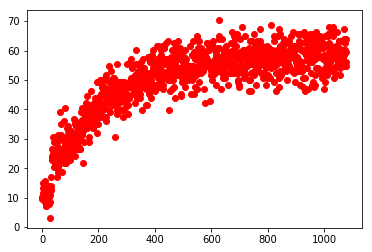

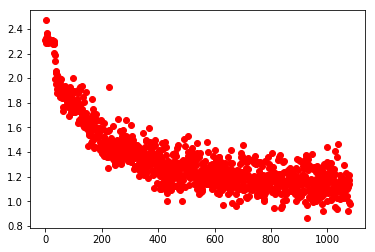

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

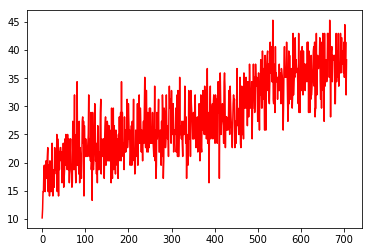

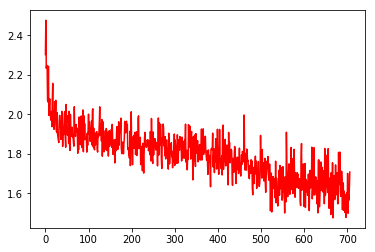

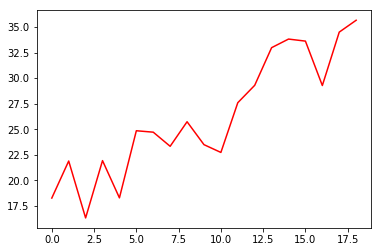

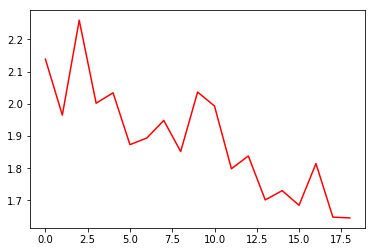

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()